## Bahdanau 注意⼒
9.7节中探讨了机器翻译问题：通过设计⼀个基于两个循环神经⽹络的编码器-解码器架构，⽤于序列到序列
学习。具体来说，循环神经⽹络编码器将⻓度可变的序列转换为固定形状的上下⽂变量，然后循环神经⽹络
解码器根据⽣成的词元和上下⽂变量按词元⽣成输出（⽬标）序列词元。然⽽，即使并⾮所有输⼊（源）词
元都对解码某个词元都有⽤，在每个解码步骤中仍使⽤编码相同的上下⽂变量。有什么⽅法能改变上下⽂变
量呢？  

我们试着从 (Graves, 2013)中找到灵感：在为给定⽂本序列⽣成⼿写的挑战中，Graves设计了⼀种可微注意⼒
模型，将⽂本字符与更⻓的笔迹对⻬，其中对⻬⽅式仅向⼀个⽅向移动。受学习对⻬想法的启发，Bahdanau等
⼈提出了⼀个没有严格单向对⻬限制的可微注意⼒模型 (Bahdanau et al., 2014)。在预测词元时，如果不是所
有输⼊词元都相关，模型将仅对⻬（或参与）输⼊序列中与当前预测相关的部分。这是通过将上下⽂变量视
为注意⼒集中的输出来实现的。

### 模型
下⾯描述的Bahdanau注意⼒模型将遵循 9.7节中的相同符号表达。这个新的基于注意⼒的模型与 9.7节中的
模型相同，只不过 (9.7.3)中的上下⽂变量c 在任何解码时间步t′都会被ct′替换。假设输⼊序列中有T个词元，
解码时间步t′的上下⽂变量是注意⼒集中的输出：  

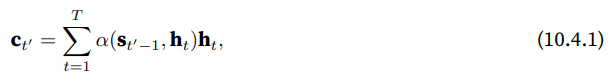

其中，时间步t′ − 1时的解码器隐状态st′−1是查询，编码器隐状态ht既是键，也是值，注意⼒权重α是使⽤
(10.3.2) 所定义的加性注意⼒打分函数计算的。

与 图9.7.2中的循环神经⽹络编码器-解码器架构略有不同，图10.4.1描述了Bahdanau注意⼒的架构。

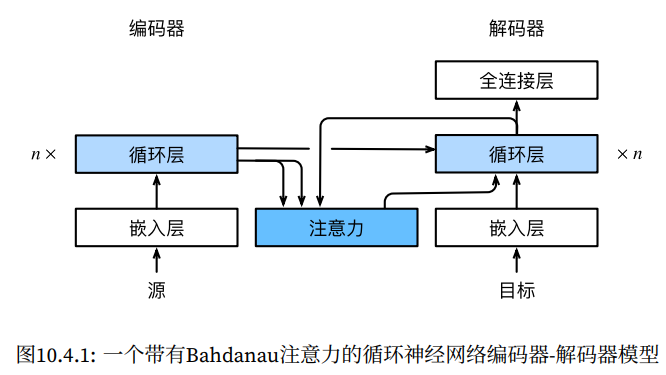




In [28]:
import torch
from torch import nn
from d2l import torch as d2l


### 定义注意力解码器
下⾯看看如何定义Bahdanau注意⼒，实现循环神经⽹络编码器-解码器。其实，我们只需重新定义解码器即
可。为了更⽅便地显⽰学习的注意⼒权重，以下AttentionDecoder类定义了带有注意⼒机制解码器的基本接
⼝。



In [29]:
#@save
class AttentionDecoder(d2l.Decoder):
    """带有注意⼒机制解码器的基本接⼝"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    
    @property
    def attention_weights(self):
        raise NotImplementedError


接下来，让我们在接下来的Seq2SeqAttentionDecoder类中实现带有Bahdanau注意⼒的循环神经⽹络解码器。
⾸先，初始化解码器的状态，需要下⾯的输⼊：
* 编码器在所有时间步的最终层隐状态，将作为注意⼒的键和值；
* 上⼀时间步的编码器全层隐状态，将作为初始化解码器的隐状态；
* 编码器有效⻓度（排除在注意⼒池中填充词元）。

在每个解码时间步骤中，解码器上⼀个时间步的最终层隐状态将⽤作查询。因此，注意⼒输出和输⼊嵌⼊都
连结为循环神经⽹络解码器的输⼊。


In [30]:
# 因为这个几个方法d2l中没有，所以自己添加！
#@save
def masked_softmax(X, valid_lens):
    """通过在最后⼀个轴上掩蔽元素来执⾏softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后⼀轴上被掩蔽的元素使⽤⼀个⾮常⼤的负值替换，从⽽其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                            value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)


#@save
class AdditiveAttention(nn.Module):
    """加性注意⼒"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使⽤⼴播⽅式进⾏求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有⼀个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [31]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
        dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = AdditiveAttention(
        num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
        embed_size + num_hiddens, num_hiddens, num_layers,
        dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
            query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
            enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

接下来，使⽤包含7个时间步的4个序列输⼊的⼩批量测试Bahdanau注意⼒解码器。


In [32]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long) # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

### 训练
与 9.7.4节类似，我们在这⾥指定超参数，实例化⼀个带有Bahdanau注意⼒的编码器和解码器，并对这个模
型进⾏机器翻译训练。由于新增的注意⼒机制，训练要⽐没有注意⼒机制的 9.7.4节慢得多。



In [37]:
#同理
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2) # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1) # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward() # 损失函数的标量进⾏“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.019, 8323.6 tokens/sec on cuda:0


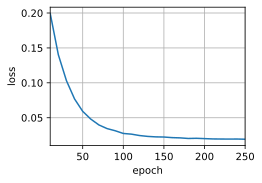

In [38]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

模型训练后，我们⽤它将⼏个英语句⼦翻译成法语并计算它们的BLEU分数。


In [41]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使⽤具有预测最⾼可能性的词元，作为解码器在下⼀时间步的输⼊
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意⼒权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # ⼀旦序列结束词元被预测，输出序列的⽣成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
        f'bleu {d2l.bleu(translation, fra, k=2):.3f}')


go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => c'est <unk> .,  bleu 0.000
i'm home . => je suis chez moi .,  bleu 1.000


## 小结
* 在预测词元时，如果不是所有输⼊词元都是相关的，那么具有Bahdanau注意⼒的循环神经⽹络编码器-解码器会有选择地统计输⼊序列的不同部分。这是通过将上下⽂变量视为加性注意⼒池化的输出来实现的。
* 在循环神经⽹络编码器-解码器中，Bahdanau注意⼒将上⼀时间步的解码器隐状态视为查询，在所有时间步的编码器隐状态同时视为键和值。

